/home/cc/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cc/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cc/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cc/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: P

Instructions for updating:
Use tf.gfile.GFile.
(636, 700, 3) <class 'numpy.ndarray'> uint8 True
===== Tensorflow RESULTS =======
0.387413s


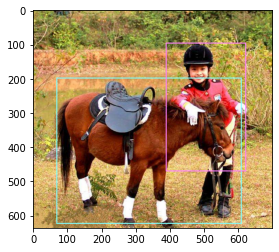

In [1]:
import numpy as np
import tensorflow as tf
import cv2 as cv
from tensorflow.tools.graph_transforms import TransformGraph
from datetime import datetime

# Read the graph.
with tf.gfile.FastGFile('frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Session() as sess:
    # Restore session
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    
    # Read and preprocess an image.
    img = cv.imread('timg.jpg')
    print(img.shape, type(img), img.dtype, img.flags['C_CONTIGUOUS'])
    rows = img.shape[0]
    cols = img.shape[1]
    inp = cv.resize(img, (300, 300))
    inp = inp[:, :, [2, 1, 0]]  # BGR2RGB
    # Run the model
    a=datetime.now()
    out = sess.run([sess.graph.get_tensor_by_name('concat:0'),
                    sess.graph.get_tensor_by_name('concat_1:0')], 
                    feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
    b=datetime.now()
    print ("===== Tensorflow RESULTS =======")
    print("%d.%ds" %((b-a).seconds, (b-a).microseconds))
    
#     print(type(out[0]))
#     print(out[0].shape)
#     print(out[0])
    
#     print(type(out[1]))
#     print(out[1].shape)
#     print(out[1])

import ctypes
from ctypes import *

lib = ctypes.cdll.LoadLibrary("./libpostprocess.so")

# x = c_float(1.0) # set func input var's type
# print(type(x))
# lib.sigmoid.restype = c_float #set func's return type

# a = lib.sigmoid(x)
# print(type(a),a)
#######################################################################

img = img.transpose((2, 0, 1)) #HWC2CHW
# img = img[:, :, [2, 1, 0]]  # BGR2RGB
img = (img/255.0-0.5)*2.0
if not img.flags['C_CONTIGUOUS']:
    img = np.ascontiguousarray(img, dtype=np.float32)
img_ctypes_ptr = cast(img.ctypes.data, POINTER(c_float))

if not out[0].flags['C_CONTIGUOUS']:
    out[0] = np.ascontiguousarray(out[0], dtype=out[0].dtype)
loc_ctypes_ptr = cast(out[0].ctypes.data, POINTER(c_float))

if not out[1].flags['C_CONTIGUOUS']:
    out[1] = np.ascontiguousarray(out[1], dtype=out[1].dtype)
cls_ctypes_ptr = cast(out[1].ctypes.data, POINTER(c_float))

# print(img.shape, type(img), img.dtype, img.flags['C_CONTIGUOUS'])
# print(out[0].shape, type(out[0]), out[0].dtype, out[0].flags['C_CONTIGUOUS'])
# print(out[1].shape, type(out[1]), out[1].dtype, out[1].flags['C_CONTIGUOUS'])

lib.post_process.argtypes = [POINTER(c_float), ctypes.c_int, ctypes.c_int, 
                             POINTER(c_float), POINTER(c_float)]
lib.post_process(img_ctypes_ptr, c_int(cols), c_int(rows), loc_ctypes_ptr, cls_ctypes_ptr)

# print(img.shape, type(img), img.dtype, img.flags['C_CONTIGUOUS'])
# img = img[:, :, [2, 1, 0]]  #RGB2BGR
img = img.transpose((1, 2, 0)) #CHW2HWC
img = (img + 1.0)*255.0/2.0
img = img.astype(np.uint8)
# print(img.shape, type(img), img.dtype, img.flags['C_CONTIGUOUS'])
if not img.flags['C_CONTIGUOUS']:
    img = np.ascontiguousarray(img, dtype=img.dtype)

# print(img.shape, type(img), img.dtype, img.flags['C_CONTIGUOUS'])

# cv.imshow('TensorFlow MobileNet-SSD', img)
# cv.waitKey(5000)

import matplotlib.pyplot as plt
img = img[:, :, [2, 1, 0]]  # BGR2RGB
plt.imshow(img)
